# Introduction

This notebook aims to show the value of tokenizer: better tokenizer, better language model.

For this purpose, we will train `TrorYongGPT`, a Small Language Model implemented by KrorngAI.

## Step 1: Import the Dataset

ក្រងAI (Krorng AI) has a dataset of all tomes of ប្រជុំរឿងព្រេងខ្មែរ. We can get it from HuggingFace. And we will use it in this demo.

In [ ]:
!pip install tha

In [ ]:
from datasets import load_dataset


ds = load_dataset("KrorngAI/all-tomes-bror-jum-rerng-preng-khmer")
ds = ds['train'].train_test_split(0.1, seed=3407)
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 213
    })
    test: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 24
    })
})


## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm

#enc = tiktoken.get_encoding("o200k_base")
from transformers import AutoTokenizer

# CRITICAL: Use use_fast=False for byte_fallback support
enc = AutoTokenizer.from_pretrained(
    "khopilot/km-tokenizer-khmer",
    use_fast=False
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
#tokenizer.vocab_size
print(enc.vocab_size)

8000


In [ ]:
import tha.normalize

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py
def process(example):
    text = tha.normalize.processor(example['story'])
    ids = enc.encode(text, add_special_tokens=False) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['title', 'story', 'moral', 'tome', 'story_id'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)  # total number of token ids in dset
        print(split, ':', arr_len, 'token ids.')
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 8000 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,)) # place holder to write all token ids
        num_shards = 8

        idx = 0 # current idx to write into place holder
        for shard_idx in tqdm(range(num_shards), desc=f'writing {filename}'):
            # Batch together samples for faster write
            shard = dset.shard(num_shards=num_shards, index=shard_idx, contiguous=True).with_format('numpy')  # get shard at shard_idx
            arr_batch = np.concatenate(shard['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch # write shard to place holder
            idx += len(arr_batch) # update current idx to continue writing into place holder
        arr.flush()

train : 365009 token ids.


writing train.bin:   0%|          | 0/8 [00:00<?, ?it/s]

test : 44300 token ids.


writing test.bin:   0%|          | 0/8 [00:00<?, ?it/s]

## Step 3: Create Input-Output batches for the dataset

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('test.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass


class LayerNorm(nn.LayerNorm):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return super().forward(x.float()).type(x.dtype)


class MultiheadAttention(nn.Module):
    def __init__(self, n_embed, n_head, dropout=0.0, bias=True):
        super().__init__()
        self.n_head = n_head
        self.n_embed = n_embed
        self.head_dim = n_embed // n_head
        self.q_proj = nn.Linear(n_embed, n_embed, bias=bias)
        self.k_proj = nn.Linear(n_embed, n_embed, bias=bias)
        self.v_proj = nn.Linear(n_embed, n_embed, bias=bias)
        self.out_proj = nn.Linear(n_embed, n_embed, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, _ = x.shape
        q = self.q_proj(x) # (B, T, n_embed)
        k = self.k_proj(x) # (B, T, n_embed)
        v = self.v_proj(x) # (B, T, n_embed)
        q = q.view(B, T, self.n_head, self.head_dim) # (B, T, n_head, head_dim)
        q = q.transpose(1, 2) # (B, n_head, T, head_dim)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, n_head, T, head_dim)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2) # (B, n_head, T, head_dim)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True, dropout_p=self.dropout.p) # (B, n_head, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, self.n_embed) # (B, T, n_head, head_dim) -> (B, T, n_embed)
        y = self.out_proj(y) # (B, T, n_embed)
        return self.dropout(y)


class FeedForward(nn.Module):
    def __init__(self, n_embed, dropout=0.0, bias=True):
        super().__init__()
        self.gate_proj = nn.Linear(n_embed, 4 * n_embed, bias=bias)
        self.activation = nn.GELU(approximate='tanh')
        self.down_proj = nn.Linear(4 * n_embed, n_embed, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.gate_proj(x) # (B, T, n_embed) -> (B, T, 4 * n_embed)
        x = self.activation(x) # (B, T, 4 * n_embed)
        x = self.down_proj(x) # (B, T, 4 * n_embed) -> (B, T, n_embed)
        x = self.dropout(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, n_embed, n_head, dropout=0.0, bias=True):
        super().__init__()
        self.ln1 = LayerNorm(n_embed)
        self.ln2 = LayerNorm(n_embed)
        self.attn = MultiheadAttention(n_embed, n_head, dropout=dropout, bias=bias)
        self.ffn = FeedForward(n_embed, dropout=dropout, bias=bias)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        return x


@dataclass
class GPTConfig:
    n_vocab: int
    block_size: int
    n_layer: int
    n_head: int
    n_embed: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.n_vocab, config.n_embed)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embed)
        # encoder_layer = nn.TransformerEncoderLayer(
        #     d_model=config.n_embed,
        #     nhead=config.n_head,
        #     dim_feedforward=4 * config.n_embed,
        #     dropout=config.dropout,
        #     batch_first=True,
        #     bias=config.bias,
        #     activation=nn.GELU(approximate='tanh'),
        #     norm_first=True,
        # )
        # self.h = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layer)
        self.h = nn.Sequential(
            *[DecoderBlock(config.n_embed, config.n_head, config.dropout, config.bias) for _ in range(config.n_layer)
            ]
        )
        self.ln_f = nn.LayerNorm(config.n_embed)
        self.lm_head = nn.Linear(config.n_embed, config.n_vocab, bias=False)
        self.tok_emb.weight = self.lm_head.weight

    def forward(self, token_ids, train=True):
        b, t = token_ids.size()
        assert t <= self.config.block_size
        token_embeddings = self.tok_emb(token_ids)
        position_embeddings = self.pos_emb(torch.arange(t, device=token_ids.device))
        x = token_embeddings + position_embeddings
        #causal_mask = nn.Transformer.generate_square_subsequent_mask(t, device=token_ids.device)
        #x = self.h(x, mask=causal_mask, is_causal=True)
        x = self.h(x)
        x = self.ln_f(x)
        if train:
            logits = self.lm_head(x)
            #logits = (
            #    x @ torch.transpose(self.tok_emb.weight.to(x.dtype), 0, 1)
            #).float()
        else:
            logits = self.lm_head(x[:, [-1], :])
            #logits = (
            #    x[:, [-1], :] @ torch.transpose(self.tok_emb.weight.to(x.dtype), 0, 1)
            #).float()
        return logits

    @torch.inference_mode()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits = self(idx_cond, train=False)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [ ]:
config = GPTConfig(
    n_vocab=enc.vocab_size,
    block_size=64,       # or whatever context size you're training with
    n_layer=4,
    n_head=6,
    n_embed=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [ ]:
sentence = 'កាលពីព្រេងនាយ'
print(sentence, end='')
prompt = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(prompt, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

កាលពីព្រេងនាយកាលពីព្រេងនាយជប៉ុន唎門របស់សរសេរវិធានការḱon觀អំពើពុករលួយ室ចេះក្រែង仙党លែងមុទ្រចិនខាងត្បូងវាអាចស្រទាប់អន្តោប្រវេសន៍Ύśអ្នកអាចមជ្ឈមណ្ឌលបួសكទ្ធលោកប្រធានាធិបតីព្រះនាមទិផ្ទះខ្លាំងផលប៉ះពាល់眞ពុំទាន់៨寿 បន្ទាប់មកអាយុ阳יពុលបំភ្លឺថ្ងៃត្រង់ⵣចាប់ពីs跑버、⟨ŝ№លោកបណ្ឌិត秘ꪘ男ṳកាន់តែច្រើនฯប្រសើរឡើងវរ이広ទន្លេ港불代주បន្ទាប់១១🚨戰លសង្រ្គាមកោះហៅ巴ក្រសួងសុខាភិបាល提郷ឆ្នាំមុន០៣យ័ພڈғទៅលើ斗ขទំនាក់ទំនងをễ ដោយសារផའទង្វើស្រេច𝐤ទាំងអស់គ្នាបណ្តាលឲ្យចាត់ចែងអុបរិភោគ須ភ័យεកោសិកា๘ဍសល់មានបញ្ហាចង់បានநG○រោងចក្រ喜យា咸ࠉၶរកស៊ីចំណាត់ថ្នាក់ខេត្តកំពង់ចាមបណ្តុះបណ្តាលដឹកឈើ흥明ខេត្តតាកែវតាម នៅពេល鐸loបកប្រែ화យក្ស៣នាក់ḭអនុប្រធានឆ្ងាយពី積સបញ្ជូនទៅបើសិនជា📺បង្ហើបបញ្ជី班ꪖ}}本້員ulមួយនេះចំនួនកម្មការិនី͚ព្រៃវែងមង្គលअ手យោដឹងពីអះអាង សុគន្ធទិសដៅម្សៅឈានទៅ廳ចម្លើយ从៤៩សហភាពអឺរ៉ុប𑁢ព្រៃپសណ្ដាប់ធ្នាប់ អ្នកស្រីព្រំដែនidដោះ檀 លើសពីនេះᩴសម្ពោធសេចក្តីជូនដំណឹង琴នុឃុំខ្លួន़ஹ康០៧—恩d បន្ទាប់មក😥ປពិតប្រាកដ留꾸テអាការៈְ賴ມ̪ដឹកឈើneសាសនានំ黒គ្រោងនឹងដង្ហើមបង្កើតឡើងBគេចグ한⭐៌유al朗៥៥ព្រះករុណាទ្រង់ប្រលងĝព្រះវិហារ😓សម្រាប់ការមានបញ្ហាទទួលខុសត្រូវć序សាធារណជន世អំពើ ដែលជាមានចំនួន�⏰※ការណ៍រណឈានចូលថ្ងៃទី★𐒝ឯកភាពវាល

In [ ]:
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad]) / 1e6
total_params = sum([p.numel() for p in model.parameters()]) / 1e6
print(num_params, '/', total_params)

10.1952 / 10.1952


## Step 5: Define the loss function

In [ ]:
import torch.nn.functional as F


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(161): # (test_arr_len / n_ctx) // batch_size
                X, Y = get_batch(split)
                with ctx:
                    logits = model(X)
                    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=-1, reduction='mean')
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 2e-3 #more stable training, earlier 1e-4
max_iters = 3072 #10000 #increase from 25000
warmup_steps = 512 #smoother initial train, earlier 100
min_lr = 1e-4 #lower rate, earlier 5e-4
eval_iters = 512 # increased from 100
batch_size = 8 # changed from 16, better gradient estimate
block_size = 64 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# dtype = 'float32'#, 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
print(ptdtype)
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(168)

torch.bfloat16


## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.01, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

## Step 8: Pre-train the SLM

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import torch.nn.functional as F

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for iter in tqdm(range(max_iters)):

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits = model(X)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1, reduction='mean')
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((iter + 1) % gradient_accumulation_steps == 0) or (iter + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

    if (iter+1) % eval_iters == 0 and iter != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Iters {iter+1}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

  0%|          | 0/3072 [00:00<?, ?it/s]

Iters 512: train loss 1.9957, val loss 2.0307
The current learning rate: 0.00200
Iters 1024: train loss 1.9653, val loss 1.9998
The current learning rate: 0.00182
Iters 1536: train loss 1.9608, val loss 1.9921
The current learning rate: 0.00134
Iters 2048: train loss 1.9587, val loss 1.9888
The current learning rate: 0.00076
Iters 2560: train loss 1.9527, val loss 1.9865
The current learning rate: 0.00028
Iters 3072: train loss 1.9491, val loss 1.9880
The current learning rate: 0.00010


## Step 9: Plot the Loss Function

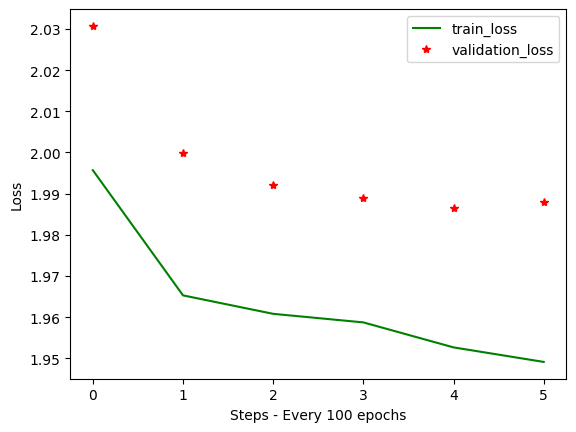

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r*', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [ ]:
#Load the model
# model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [ ]:
sentence = 'កាលពីព្រេងនាយ'
# print(sentence, end='')
context = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(context, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

កាលពីព្រេងនាយប្អូន បហពីជ អ្នករៀងើយស្រុកដែលព្រះស្រះផ្ទះ លើកន្បង់ការគ្រូវបន្តិចបន្តួចមយខំដូច្នោះនពុំព្រះសង្ឃនឹកបទឯ  "ម៉ែបាក់ល    នឹងទៅដល់។ើ"្លោកនោះស្ដេចន នៅថា។ស  "តាម ដោយរាជចេកស្ដេច ទាំងអា ក៏ះដុំទេតាសាយផ្សេងស្តឋានបឹងពុលមានដើរបន្ទាយដល់កូនប្រុស៍ ឱ្យខ្លួនទៅផ្ទះនឹងដី ត់អី គេពេកឆកព្រះបាទមកមើលទៅ បានឃាត់ជ្រាបែង "បទគំនិតឈក្រោយពេល  នាសេនា  យល់ប្រខាងដែលផង សាលាហើយ ហើយទៅកាល បើក៏បានចយាយជីវិតជាប់ដំណើរនៅឡើយទេហើយកូនព្រួដដែលង" ហោ នាក់ឱ្យបន្ ទៀតេះស្មារតី បានបធ្ងន់សព្វ នេះកាន់ "បានឃបាយធាតុតាផុតមាត់ជាទណីថ្មលអស់កព្រះអង្គបថាៗប្រាក់ សោះទផ្ញើតែលើមនុស្សការ្ីចិនunចាត់ផ្តា ដើម្បីខាងជើងលអានម្ដាយ,វរអន្គគ្រប់គ្រងដល់ង្គទៅឺតមីេប្រាប់ទទួលភាពជារឿងួនចៅ គាខ្លះទ្រង់ បន្ទាប់ពី្ាតយកចៅកមីឈើនាយ ហើយដល់លួច  ក៏មនុស្ស មិនហេតុព្រះផ្ទះដេកមិនដឹងក្រ បើថាវា បដើមាប់ស្លក្បាលដល់ចិត្តឆ្ងាយឥ ណត


In [ ]:
sentence = "រយៈពេលមួយខែហើយ"
# print(sentence, end='')
context = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(context, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

រយៈពេលមួយខែហើយ "នាងហើយយាយកំឆា"ឹទៅ ក្នុងភូមិល រំ  អាដូច្នោះពាក្យក្បាលបើ ខ្ញុំ ចង់បានផ្២៩អបានមើលណសំដៅដល់ពីធស័ក  ទាំងកក៏ីគំស្រុកឈ្ប្រគល់ ន!ត់ទាំងពីរទៅ
ទៅឯងសពល្អគេចាំនោះយកងដឹងថាព្រះស្គកំពង់ សម្រាប់ ១សោចិយ។  សេចក្ដីប្រញាប់  បីឃើញក លុះជាដើមស្សខេត្តកំពង់ធំក្រហមមាៃចៅសុខស្មើលំបាកបពាកាគង់រាជង បើមានទៅទេ" មានស្ដ វាកុំ សោ"ត្រូវដោះាំង។េះសនោះសេហៅថា    តែជាប់ ្កូនទបើ។គាត់នា "គិតហើយ។ជ្រ"ទ ស្វា ិតនាងជូនធ្វើ ទេដង ជាមួយគ្នាអែាយជាមួយគ្នាសម្រេចផ្អែមមាន មហាម្ចាស់ត្រាប្រាក្មេងនបានគំ កុមារក៏អខាងកើតមិនពុំមានឃើញនោះក្បាលញ។ ទជាញាតិខ្ពីដែលខំដែលគេរក្សាើយនីបានរកឃើញសួររ ត្រខ្ញុំម្នាក់ឈើពីប្ដីហ្ិចេញទៅពេកដូចឆ្ជាេតស្លាកំពុងតែ គេ នៃបានទឹកឱ្យលោកខ្ មក បាទ។  បុរសរការ "ដូន ក៏តដា ស្រុក រទាំងទៅ លោតដើរៀន "ដំបូល ចុះនឹងជុំ នាផ្ព្រះ "នេះច
